# 基于UNET实现高光谱数据的多标签语义分割

In [4]:
%matplotlib inline
import os,gc
import cv2
from visdom import Visdom
from UNet import *
from utils_pytorch import *

from sklearn.metrics import accuracy_score
import h5py
import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torch import optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary

transform = transforms.Compose([
    transforms.ToTensor()
])


In [5]:
if __name__ == '__main__':
    hdf5_path =  r"./data/hyper_pca_6b_4c_288.hdf5" 
    weight_path =''#r'./data/unet_hy_8.pth'       #预训练权重（可有可无）
    weight_path_out =r'./data/unet_hy_9.pth'   #权重保存位置
    input_channl = 6
    num_classes = 5                         # +1是背景也为一类    
    input_height = 256
    input_width = 256
    batch_size = 8
    epochs = 10

    
    #数据准备
    img_data = Dataset_hdf5(hdf5_path,num_classes)
    #train_dataset, test_dataset = train_test_dataset(img_data, 0.8)
    trainloader = DataLoader(img_data, batch_size,shuffle=True)
    
    
    # 读取模型
    net = UNet_1(input_channl,num_classes)
    
    #  读取与训练权重
    if  os.path.exists(weight_path):
        net.load_state_dict(torch.load(weight_path))
        print('Weight read succeeded！')
 

    max_lr = 0.012
    min_lr = 0.0001 
    snapshot = 4
    momentum = 0.9 
    weight_decay = 1e-4 
    loss_fn = nn.CrossEntropyLoss()
    scheduler_step = epochs // snapshot
    opt = torch.optim.SGD(net.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)
    # 余弦退火学习率
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, scheduler_step, min_lr)
    #定义两个数组
    train_Loss = []
    
    train_Acc  = []

    # 训练过程
    for epoch in range(epochs):
        
        net.train()   # 将模型改为训练模式
        loss = 0
        acc = 0
        for i, (image, segment_image) in enumerate(trainloader):

            out_image = net(image) 
            #train_loss = loss_fn(out_image, segment_image )
            train_loss = loss_fn(out_image, segment_image.long()).requires_grad_()

            train_acc  = acc_fn(out_image, segment_image)
            opt.zero_grad()
            train_loss.backward()
            opt.step()
            
            loss += train_loss.item()* image.shape[0]         #记录每个样本的损失

            acc += train_acc
            if i % 5 == 0:
                print(f'{epoch}-{i}-train_loss===>>{train_loss.item()}    acc:{acc}')
        lr_scheduler.step()    #学习率更新
        train_Loss.append(loss / len(trainloader))
        train_Acc.append(acc / batch_size)
        


        
        if epoch % 2 == 0:
            torch.save(net.state_dict(), weight_path_out)   #保存权重
            print('save successfully!')
            
        gc.collect()
        torch.cuda.empty_cache()
    
    torch.save(net.state_dict(), weight_path_out)   #保存权重
    print('save successfully!')

    


389.0 3934.0
0.0 23896.0
0-0-train_loss===>>1.5590007305145264    acc:0.3948192596435547
0-5-train_loss===>>1.5297778844833374    acc:1.7466602325439453
0-10-train_loss===>>1.537319540977478    acc:3.7115402221679688
0-15-train_loss===>>1.5226435661315918    acc:5.649280548095703
0-20-train_loss===>>1.4628239870071411    acc:7.598386764526367
0-25-train_loss===>>1.407333254814148    acc:9.560346603393555
0-30-train_loss===>>1.3907040357589722    acc:11.485124588012695
0-35-train_loss===>>1.3282325267791748    acc:13.31281852722168
save successfully!
1-0-train_loss===>>1.2347285747528076    acc:0.4556236267089844
1-5-train_loss===>>1.2579927444458008    acc:2.6274852752685547
1-10-train_loss===>>1.1957520246505737    acc:5.096372604370117
1-15-train_loss===>>1.597246527671814    acc:6.957292556762695
1-20-train_loss===>>1.3519563674926758    acc:8.931385040283203
1-25-train_loss===>>1.3468341827392578    acc:10.866626739501953
1-30-train_loss===>>1.3467423915863037    acc:12.60375022888

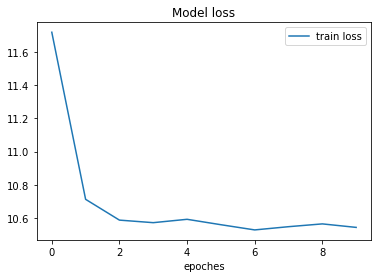

In [6]:
plt.plot(np.arange(len(train_Loss)), train_Loss,label="train loss")

#plt.plot(np.arange(len(train_Acc)), Accuracy_list, label="train acc")

plt.legend() #显示图例
plt.xlabel('epoches')
#plt.ylabel("epoch")
plt.title('Model loss')
plt.show()